# Electric Network Frequency Analysis
This Notebook is supposed to act as a step-by-step explanation of the
[Electric Network Frequency (ENF) Analysis script](https://github.com/Wuelle/enf_analysis) i made. 
I assume that the reader is familiar with the basic concept of a Fourier Transformation.
If you want to follow along, please run the downloader script and place an arbitrary audio sample in the `data/` directory.
## Table of Contents
* [Introduction](#Introduction)
* [Fourier Transformation](#Fourier-Transformation)
* [Short-time Fourier Transform](#Short-time-Fourier-Transform)

## Introduction
The european powergrid runs on alternating current, with a frequency of, in theory, exactly 50 Hertz. In practice however,
this value fluctuates due to changes in supply and demand. These Fluctuations are usually in the order of < 1Hz and do not affect everyday consumers at all.
<p>
    Another thing to realize is that alternating current can leave ENF-Artifacts in audio recordings.
    The noise is know as the <a href=https://en.wikipedia.org/wiki/Mains_hum>Mains Hum</a> and in its pure 50 Hz form, it
    is too deep to be heard by a human ear. 
</p>
<p>
Luckily, the british <a href=https://data.nationalgrideso.com>National Grid ESO</a> provides a 
<a href=https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources>free dataset</a> of these frequency variations since January of 2019, which we can use to get the historical data. They record the frequency once per second, which is a lot more than i had initially hoped for.
</p>

If however, we extract this background noise and match it with the values from the dataset, we can exactly timestamp the recording.
This process has already been used in court to verify the authenticity of provided audio or to detect evidence of tampering.(because the <abbr title="Electric Network Frequency">ENF</abbr> would suddenly jump around)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.fft import fft

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,5)

## Fourier Transformation
The exact Algorithm is beyond the scope of this document, however the Youtube Channel [3b1b](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw) provides an [excellent in-depth Explanation](https://www.youtube.com/watch?v=spUNpyF58BY).<br>
TLDR;<br>
A Fourier Transformation is a process by which the underlying frequencies of a noisy signal can be extracted.<br>

The [data](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) has a resolution of one sample per second. So there is no need to calculate anything more precise than that since we would just be overfitting the data anyway.

In [28]:
from scipy.io import wavfile
samplerate, data = wavfile.read("data/input2.wav")
data = data[:, 0] # convert to mono
print(samplerate, data.shape)

48000 (6420411,)


Just slicing the wave file to the size of a window is insufficient, since it artificially creates edges at the start and end of the window. To avoid this, we multiply the window by a half cosine function to ensure a smooth transition. (This is called a [Hanning Window](https://numpy.org/doc/stable/reference/generated/numpy.hanning.html))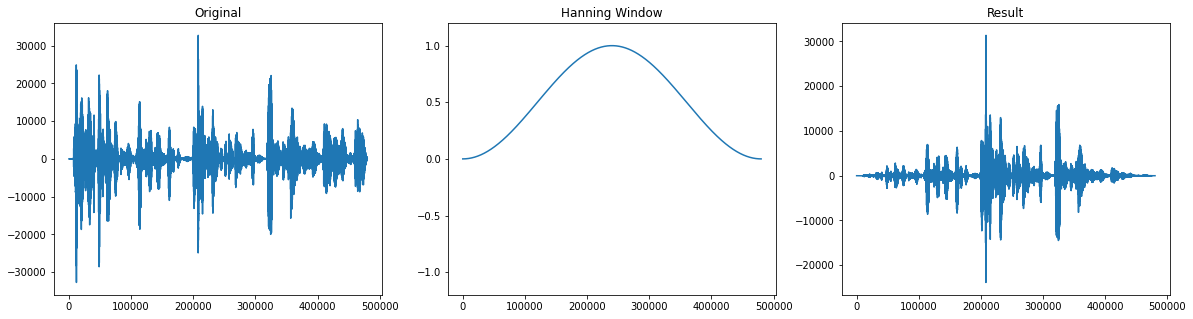

### Nyquist Frequency
The mathematical nature of the Fourier Transformation imposes a limit on the frequency that can meaningfully be analyzed.
This limit is called the [Nyquist Frequency](https://en.wikipedia.org/wiki/Nyquist_frequency) and its always equal to the number of samples divided by two.
Luckily we need not concern ourselves with this, since we are interested in the frequency activity between 49Hz and 51Hz, 
any window with more than 100 samples (which at a sample rate of 48000 samples per second would be 1/480th of a second long) will suffice.

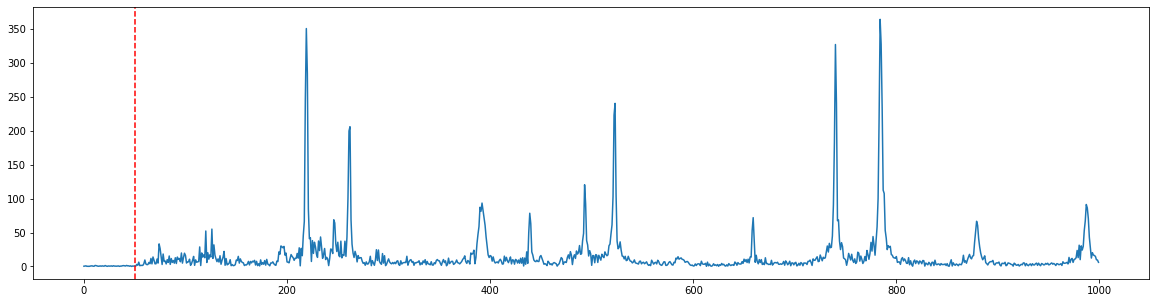

In [29]:
fourier = np.abs(fft(data[:samplerate]))[:1000] / samplerate
plt.plot(fourier)
plt.axvline(x=50, color='red', linestyle='--')
plt.show()

We can clearly see the spike at approximately 50Hz. This is the noise created by the electric network that we are looking
for. If, at this point, you do not see a spike, the audio does not contain that noise and it cannot be timestamped using the
algorithm.

## Short-time Fourier Transform
This, however, is just a Fourier transform of the first second.<br>
Since we are interested in how the frequency varies over time, we need to compare multiple transformations against each other. This process is known as a [Short-time Fourier Transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)<br>
A samplerate of 48000 means that to get one Fourier transform per second, we need to offset our sliding window by 48000 samples each time. Since we expect a frequency of around 50 Hertz, a window size of 5 seconds, amounting to ~250 cycles should be more than sufficient.<br>
The next question is: How far should the sliding window shift after each iteration? This will determine the resolution of our final frequency graph. Since the [data](https://data.nationalgrideso.com/system/system-frequency-data?from=0#resources) only lists one data point per second, calculating anything more than that would just be overfitting the data. If you want to use this with your own dataset, you might want to adjust this value.

In [30]:
window_length = 5 # length of the window in seconds
window_size = samplerate * window_length # number of samples per window
n_windows = 1000 # total number of windows
offset = 1000 # offset of each window
fft_size = 1000
result = np.empty((n_windows, fft_size))

In [47]:
%%time
for ix in range(n_windows):
    window = data[ix * offset:ix * offset + window_size]
    window = window * np.hanning(window_size)
    fourier = np.abs(fft(window)) / window_size
    result[ix] = fourier[:fft_size]
result = 20 * np.log10(result)

Wall time: 1min 1s


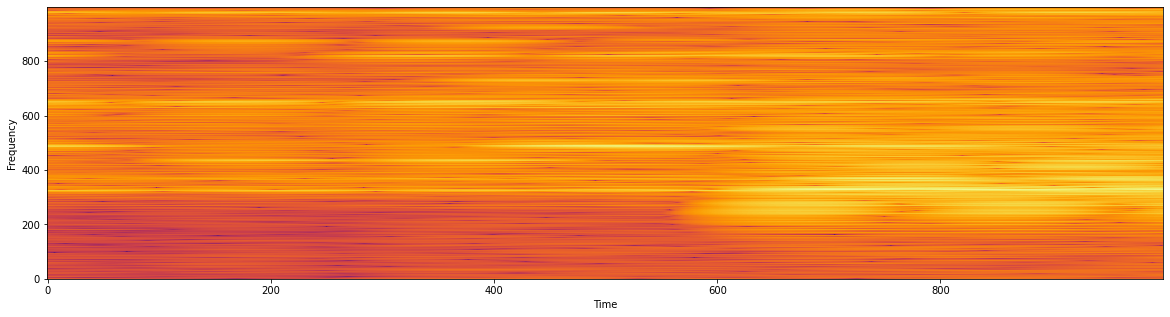

In [48]:
plt.imshow(result.transpose(), cmap="inferno", interpolation="nearest", aspect="auto", origin="lower")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

Now, is this just a slower, more complicated version of `plt.specgram`?<br>
Yes. But i feel like its worth understanding whats going on behind the scenes.